In [1]:
from pathlib import Path
import random

from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from patterns_search.augmentations import (
    Augmentation,
    AugmentationParameter,
    drop_random_points,
    remove_random_regions,
)
from patterns_search.searchers import CorrelationSearcher
from patterns_search.utils import make_vertical_pattern_target_plot

random.seed(42)
np.random.seed(42)

In [2]:
rcParams["figure.figsize"] = (8, 9)  # Plots' size

In [3]:
def plot_well_log(depth: np.array, sp: np.array, title: str = ""):
    ax = plt.subplot()
    ax.plot(sp, depth)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title(title)
    return ax

## Поиск кривой Муромцева

In [4]:
muroms_path = Path("data/Murom/")

patterns = {
    file.name: pd.read_excel(file, usecols=["Dept", "SP"]) for file in muroms_path.glob("*")
}

pattern = patterns["Shallow marine_Устьевых баров.xlsx"]

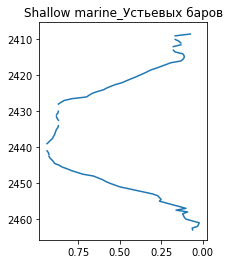

In [5]:
plt.figure(figsize=(3, 4))

plot_well_log(depth=pattern["Dept"].to_numpy(), sp=pattern["SP"].to_numpy(), title="Shallow marine_Устьевых баров");

В Dept есть пропущенные значения. Исправим это

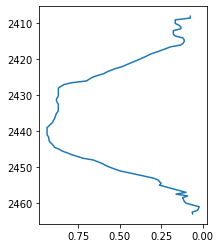

In [6]:
new_dept = np.arange(min(pattern["Dept"]), max(pattern["Dept"])+.0001, 0.1)
pattern["Dept"] = new_dept

plt.figure(figsize=(3, 4))
plot_well_log(pattern["Dept"].to_numpy(), pattern["SP"].to_numpy());

Прочитаем данные, в которых будем искать кривую

In [7]:
df = pd.read_pickle("data/New_dataset.pkl")
df.head(3)

,Well,Top,Bottom,Thickness,ind_top,ind_bot,sp,dept,code
0,101P_y-kin,2890.89,2924.37,33.48,28895,29230,"[146.83500671, 146.7230072, 145.58999634, 144....","[2890.88, 2890.98, 2891.08, 2891.18, 2891.28, ...","[nan, nan, nan, nan, nan, nan, nan, nan, 16.0,..."
1,105_unt,2886.79,2899.94,13.15,1384,1450,"[137.37800598, 137.75500488, 138.05000305, 138...","[2886.8, 2887.0, 2887.2, 2887.4, 2887.6, 2887....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,107_unt,2912.93,2930.13,17.2,9649,9700,"[113.917099, 113.74120331, 113.51339722, 113.2...","[2913.02, 2913.22, 2913.42, 2913.62, 2913.82, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


Выберем скважину, в которой мы знаем, что есть устьевой бар

In [8]:
df[df["Well"] == "373_ach"]

,Well,Top,Bottom,Thickness,ind_top,ind_bot,sp,dept,code
223,373_ach,3095.43,3123.91,28.48,1327,1470,"[113.52380371, 111.37580109, 105.85430145, 95....","[3095.4, 3095.6, 3095.8, 3096.0, 3096.2, 3096....","[nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


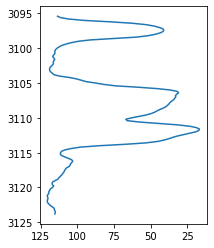

In [9]:
well = df.iloc[223]

plt.figure(figsize=(3, 4))
plot_well_log(depth=well["dept"], sp=well["sp"]);

Отшкалируем SP, чтобы измерения принадлежали интервалу [0; 1]

C:\Users\vladi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


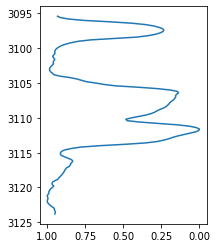

In [10]:
scaler = MinMaxScaler()
well["sp"] = scaler.fit_transform(well["sp"].reshape(-1, 1)).flatten()

plt.figure(figsize=(3, 4))
plot_well_log(depth=well["dept"], sp=well["sp"]);

Попробуем найти кривую Муромцева в каротаже

Создадим набор аугментаций. Это функции, которые будут немного видоизменять паттерн, который мы ищем. Это позволит найти кривую даже если она не совсем похожа на эталонную

Аугментации можно создать с помощью класса **Augmentation** из `patterns_search.augmentations`. Первым параметром этот класс принимает название функции для видоизменения кривой. Сейчас доступны следующие функции:
* `drop_random_points` — удаляет случайные точки из кривой. Это позволяет "сжать" кривую, почти не изменяя её форму. Эта аугментация контролируется параметром **keep_probability** — вероятностью для каждой точки быть выброшенной
* `insert_points` — вставляет новые точки в случайные места исходной кривой. Значения новой точки вычисляются с помощью линейной интерполяции. Эта аугментация немного растяшивает кривую почти не изменяя её форму. Параметр функции — **insertion_probability** определяет вероятность добавить новую точку после каждого измерения в массиве
* `stretch_function` — вставляет новые значения по тому же принципе, что и функция *insert_points*. Позволяет "растянуть" кривую в несколько раз. Величина растяжения определяется параметром **stretching_coef**
* `remove_random_region` — удаляет случайный участок из кривой. Параметр функции — **region_size**: количество точек, которые будут удалены из массива
* `remove_random_regions` — удаляет несколько случайных участков из кривой. У этой агументации два параметра: **fraction** — доля точек, которые будут удалены для каждого участка и **n_regions** — количество участков, которые будут удалены. Например, `remove_random_regions` с параметрами `fraction=15` и `n_regions=3` удалит три учатска, каждый из которых будет длиной в 1/15 от исходной кривой

Для того, чтобы создать аугментацию, нужно создать экземпляр класса `Augmentation` и передать ему следующие параметры:
* `fun` — одна из функций, описанных выше
* `fun_parameters` — список экзеспляров класса `AugmentationParameter`. Каждый из них описывает название параметра из описания выше (или документации функций), а также `generating_function` — функцию для случайной генерации параметра. Это позволит получать новую кривую, каждый раз вызывая одну и ту же аугментацию. Задать параметры генерации можно с помощью словаря `generating_parameters`

Проще всего понять на примере:

In [11]:
augmentations = [
    Augmentation(
        fun=drop_random_points,
        fun_parameters=[
            AugmentationParameter(
                name="keep_probability",
                generating_function=np.random.uniform,
                generating_parameters={"low": 0.1, "high": 0.5},
            ),
        ]
    ),
    
    Augmentation(
        fun=remove_random_regions, 
        fun_parameters=[
            AugmentationParameter(
                name="fraction",
                generating_function=np.random.randint,
                generating_parameters={"low": 10, "high": 20}
            ),
            AugmentationParameter(
                name="n_regions",
                generating_function=np.random.randint,
                generating_parameters={"low": 2, "high": 4}
            ),
        ]
    ),
]

Мы создали список из двух аугментаций. Первая будет случайным образом выбрасывать от 10 до 50% точек из кривой. Вторая будет выбрасывать от 2 до 3 случайных регионов, каждый из которых будет иметь длину от 1/20 до 1/10 от длины паттерна, который мы ищем

Теперь можно искать паттерн:

In [12]:
searcher = CorrelationSearcher(
    pattern=pattern["SP"].to_numpy(),
    target=well["sp"],
    augmentations=augmentations,
    pattern_target_ratio=1.
)

Сгенерируем 5 аугментированных кривых. Благодаря паре классов, весь поиск осуществляется в несколько строчек кода :)

In [13]:
searcher.search(n_tries=5)

C:\Users\vladi\PycharmProjects\patterns_search\patterns_search\utils.py:75: UserWarning: Length of sequence_1 is less than length of sequence_2. Swapping sequences
  "Length of sequence_1 is less than length of sequence_2. Swapping sequences"


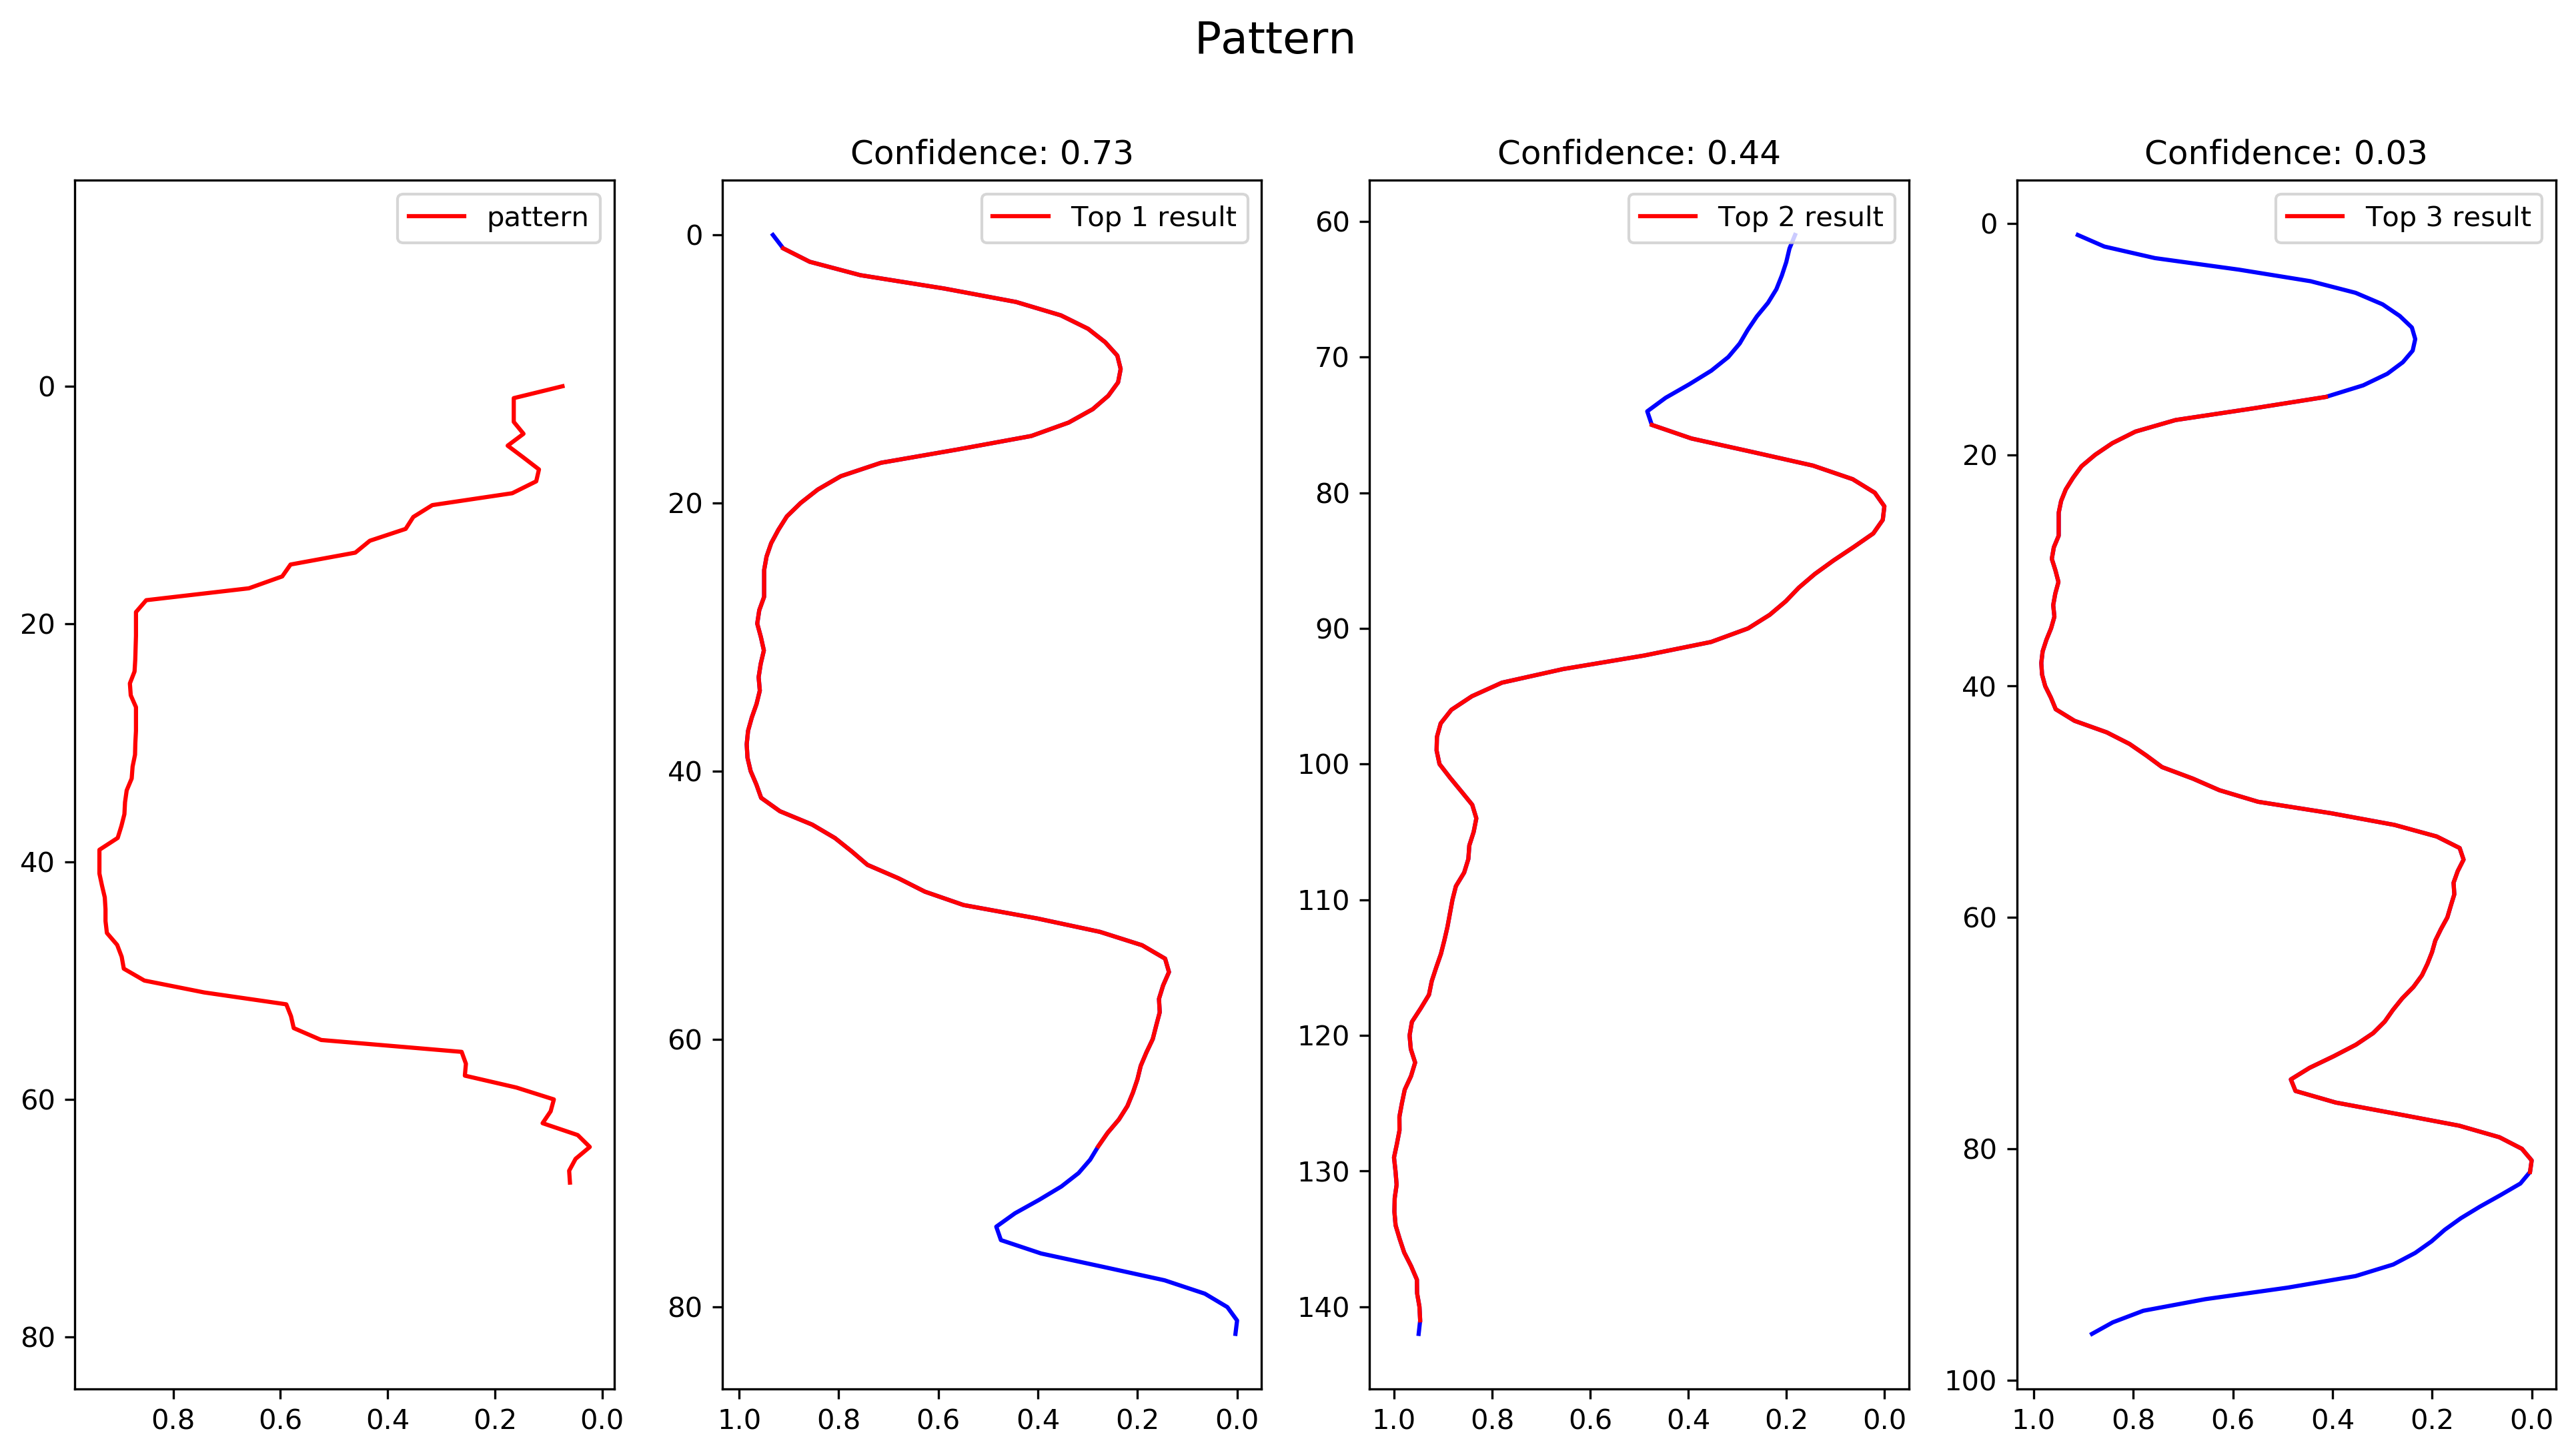

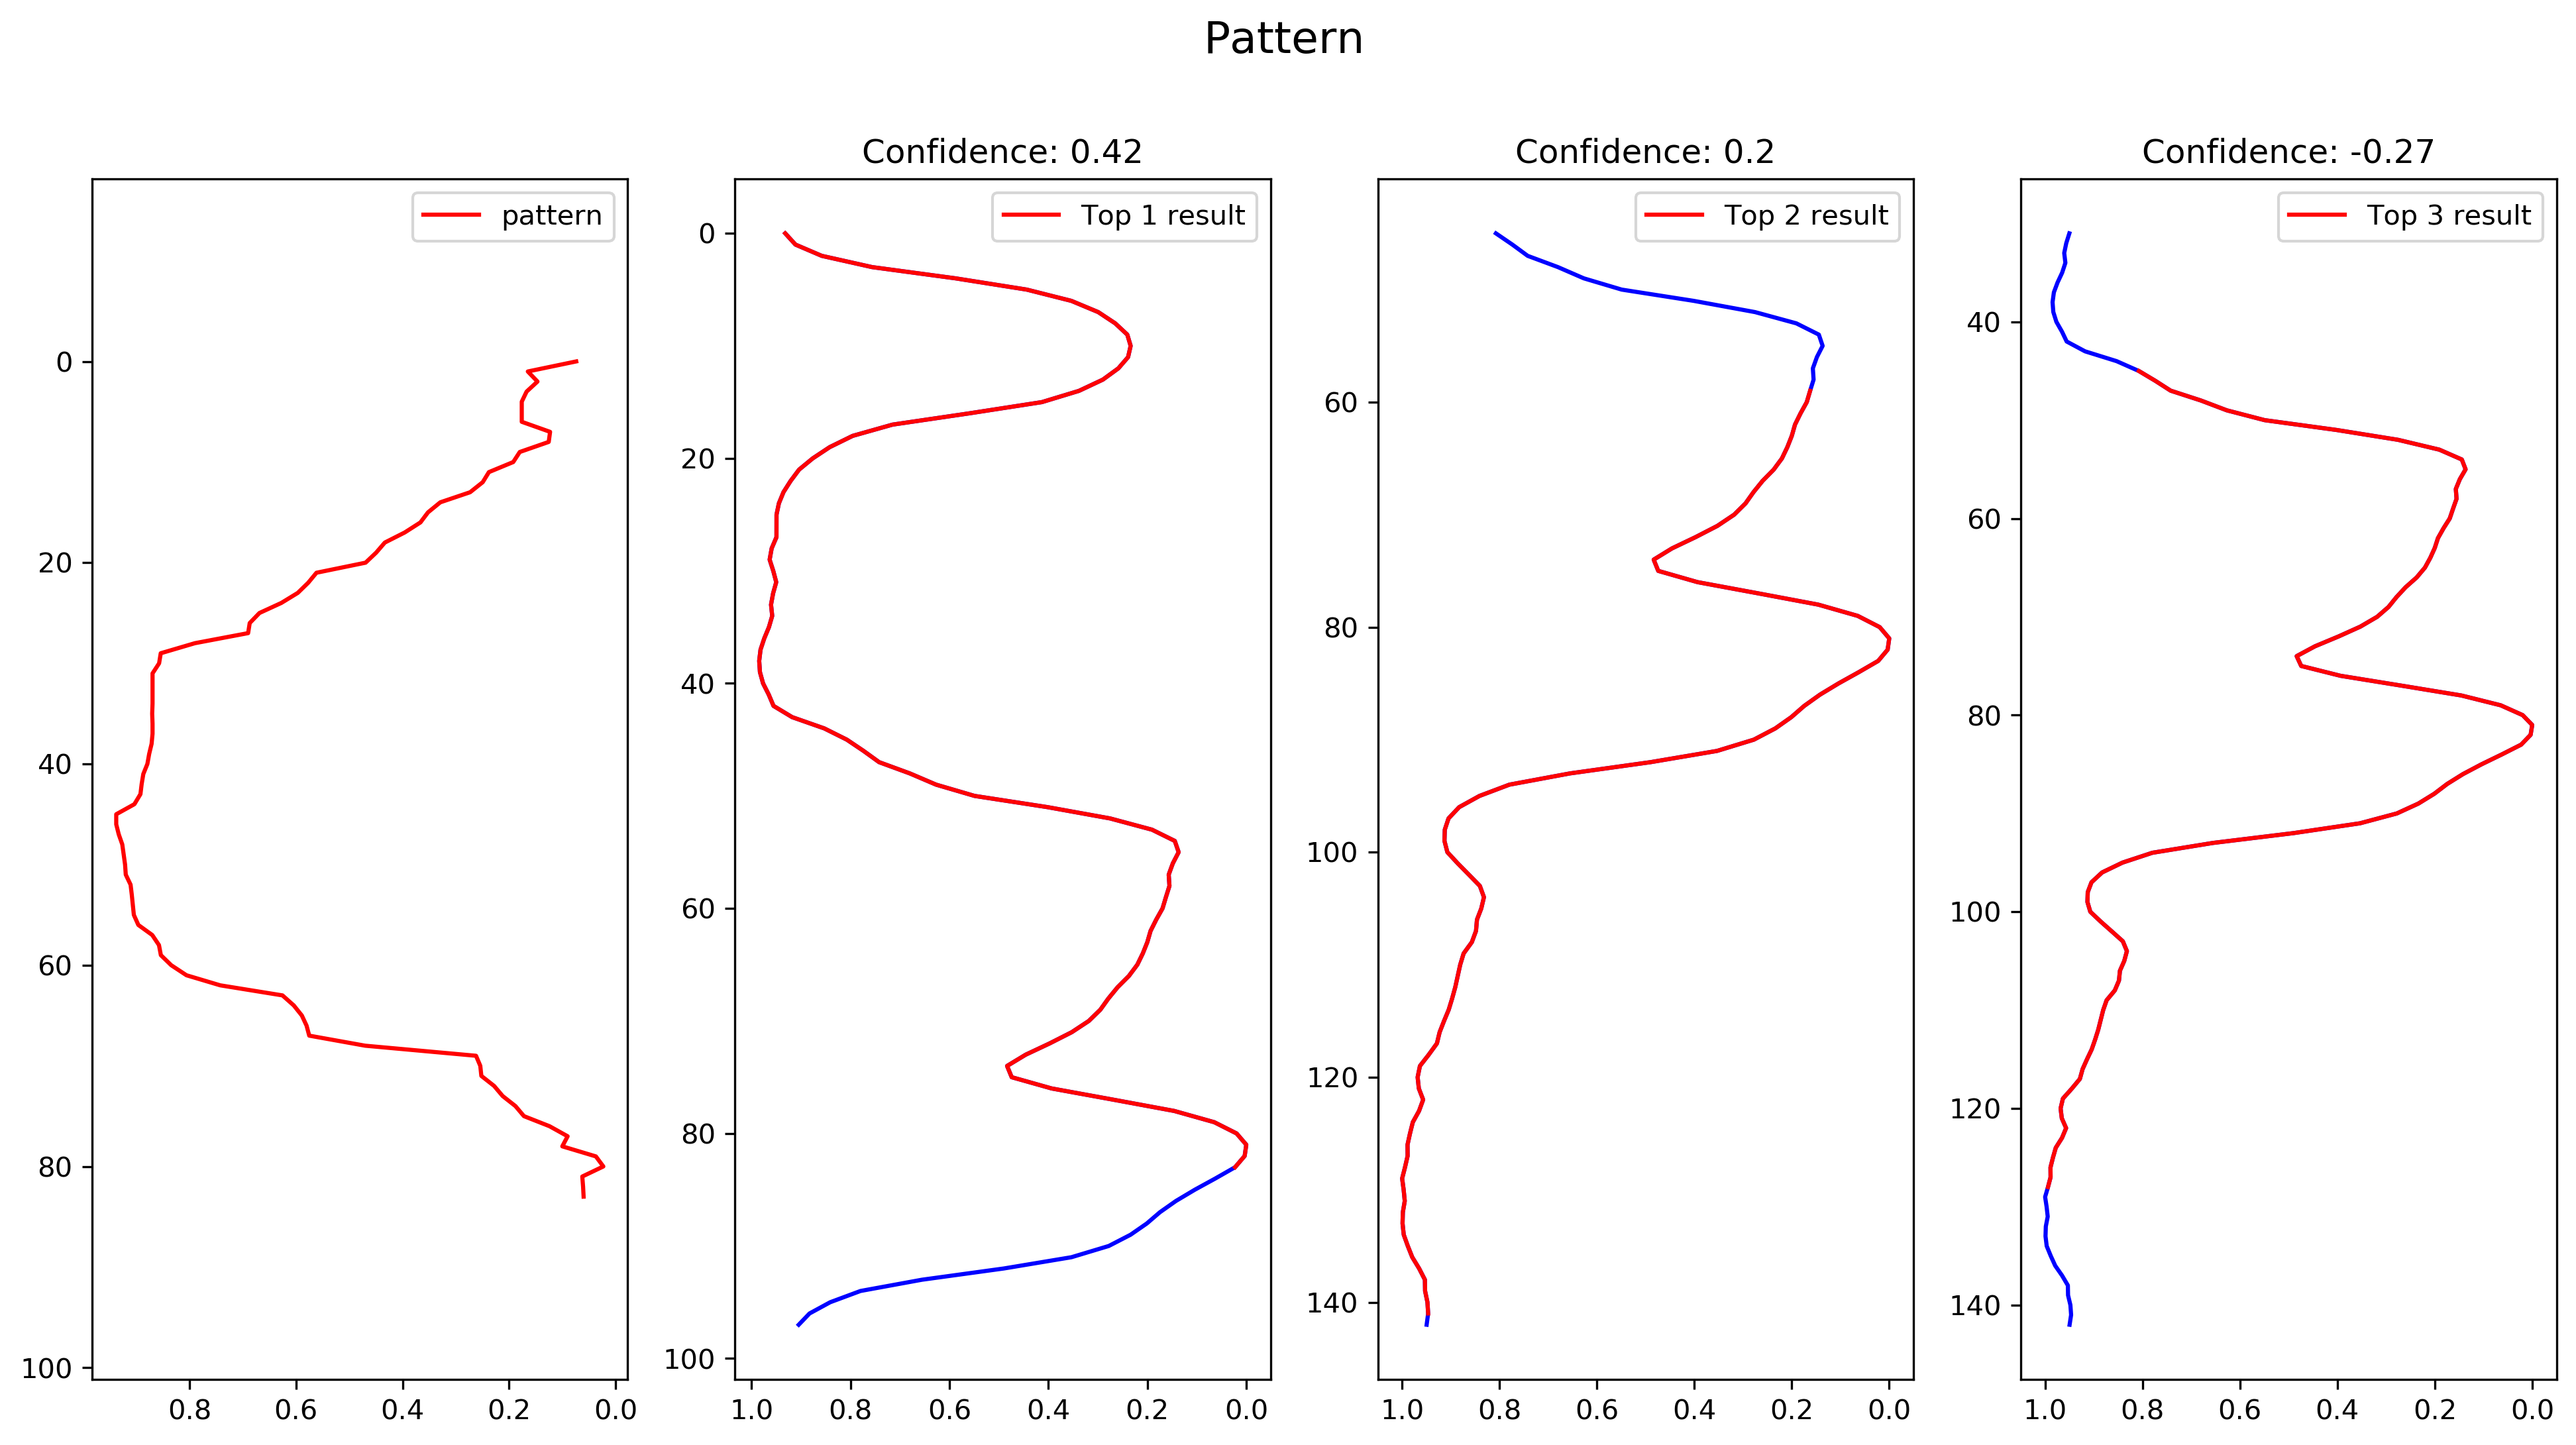

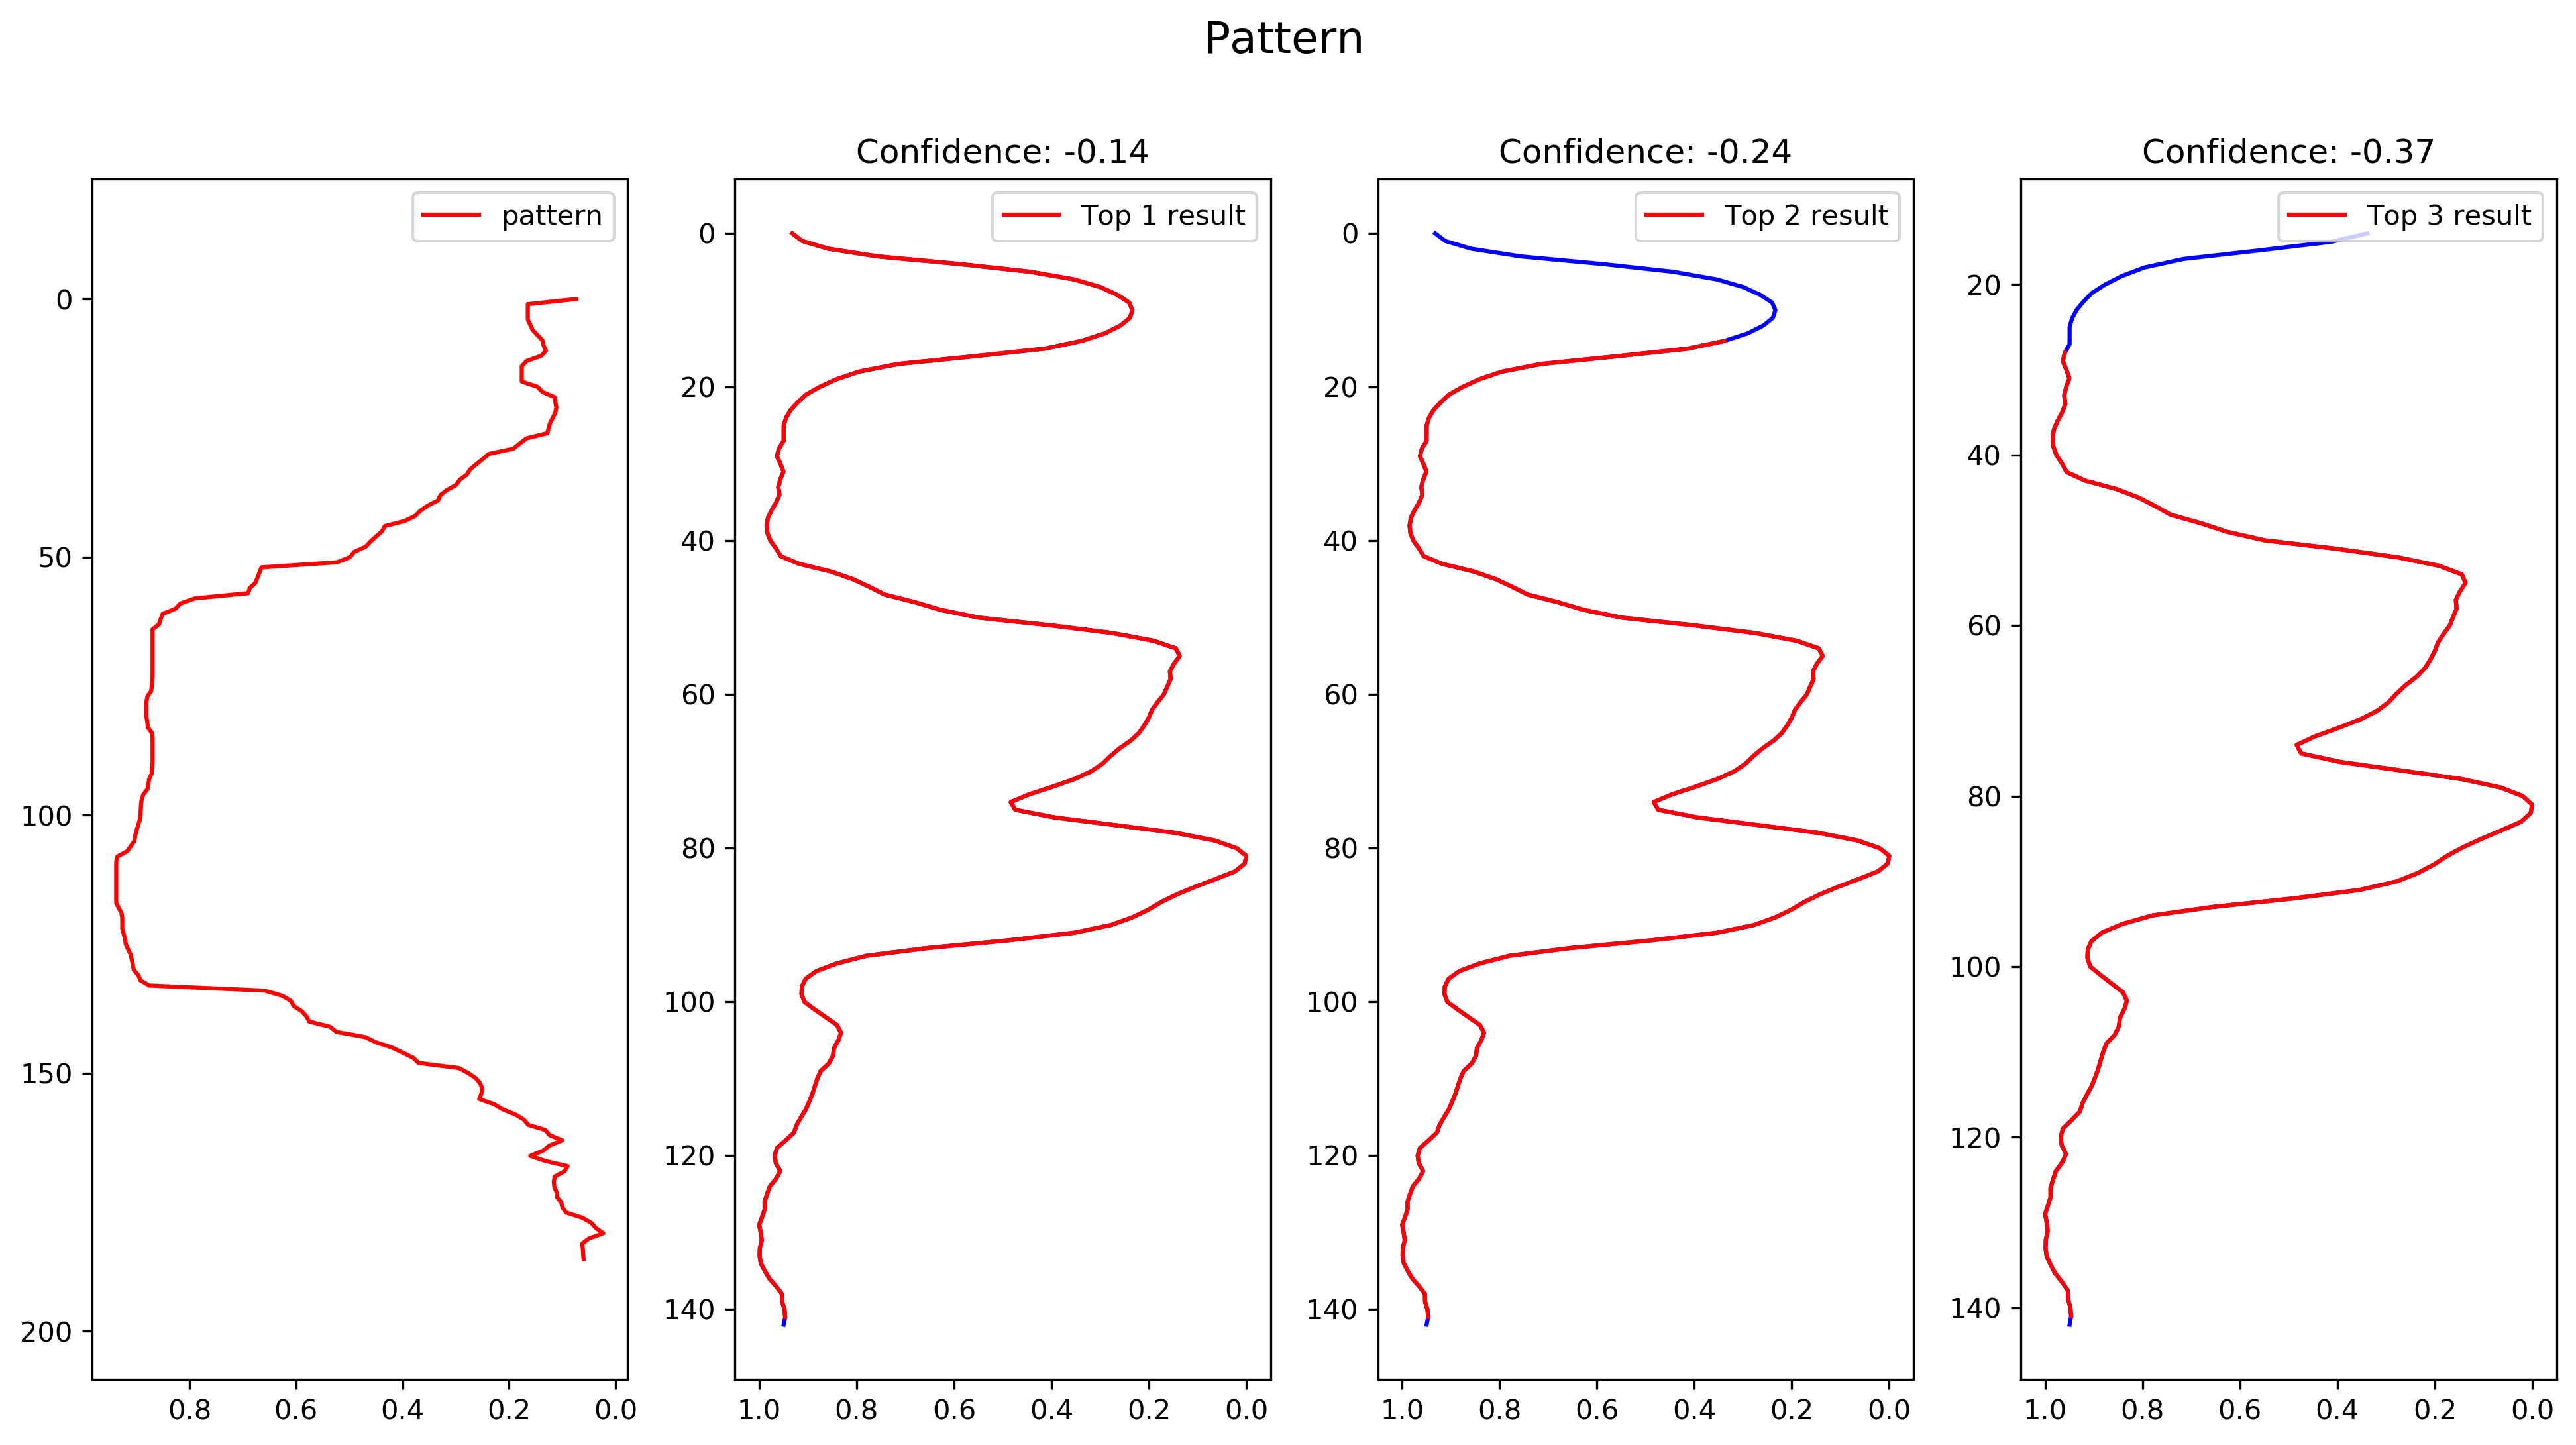

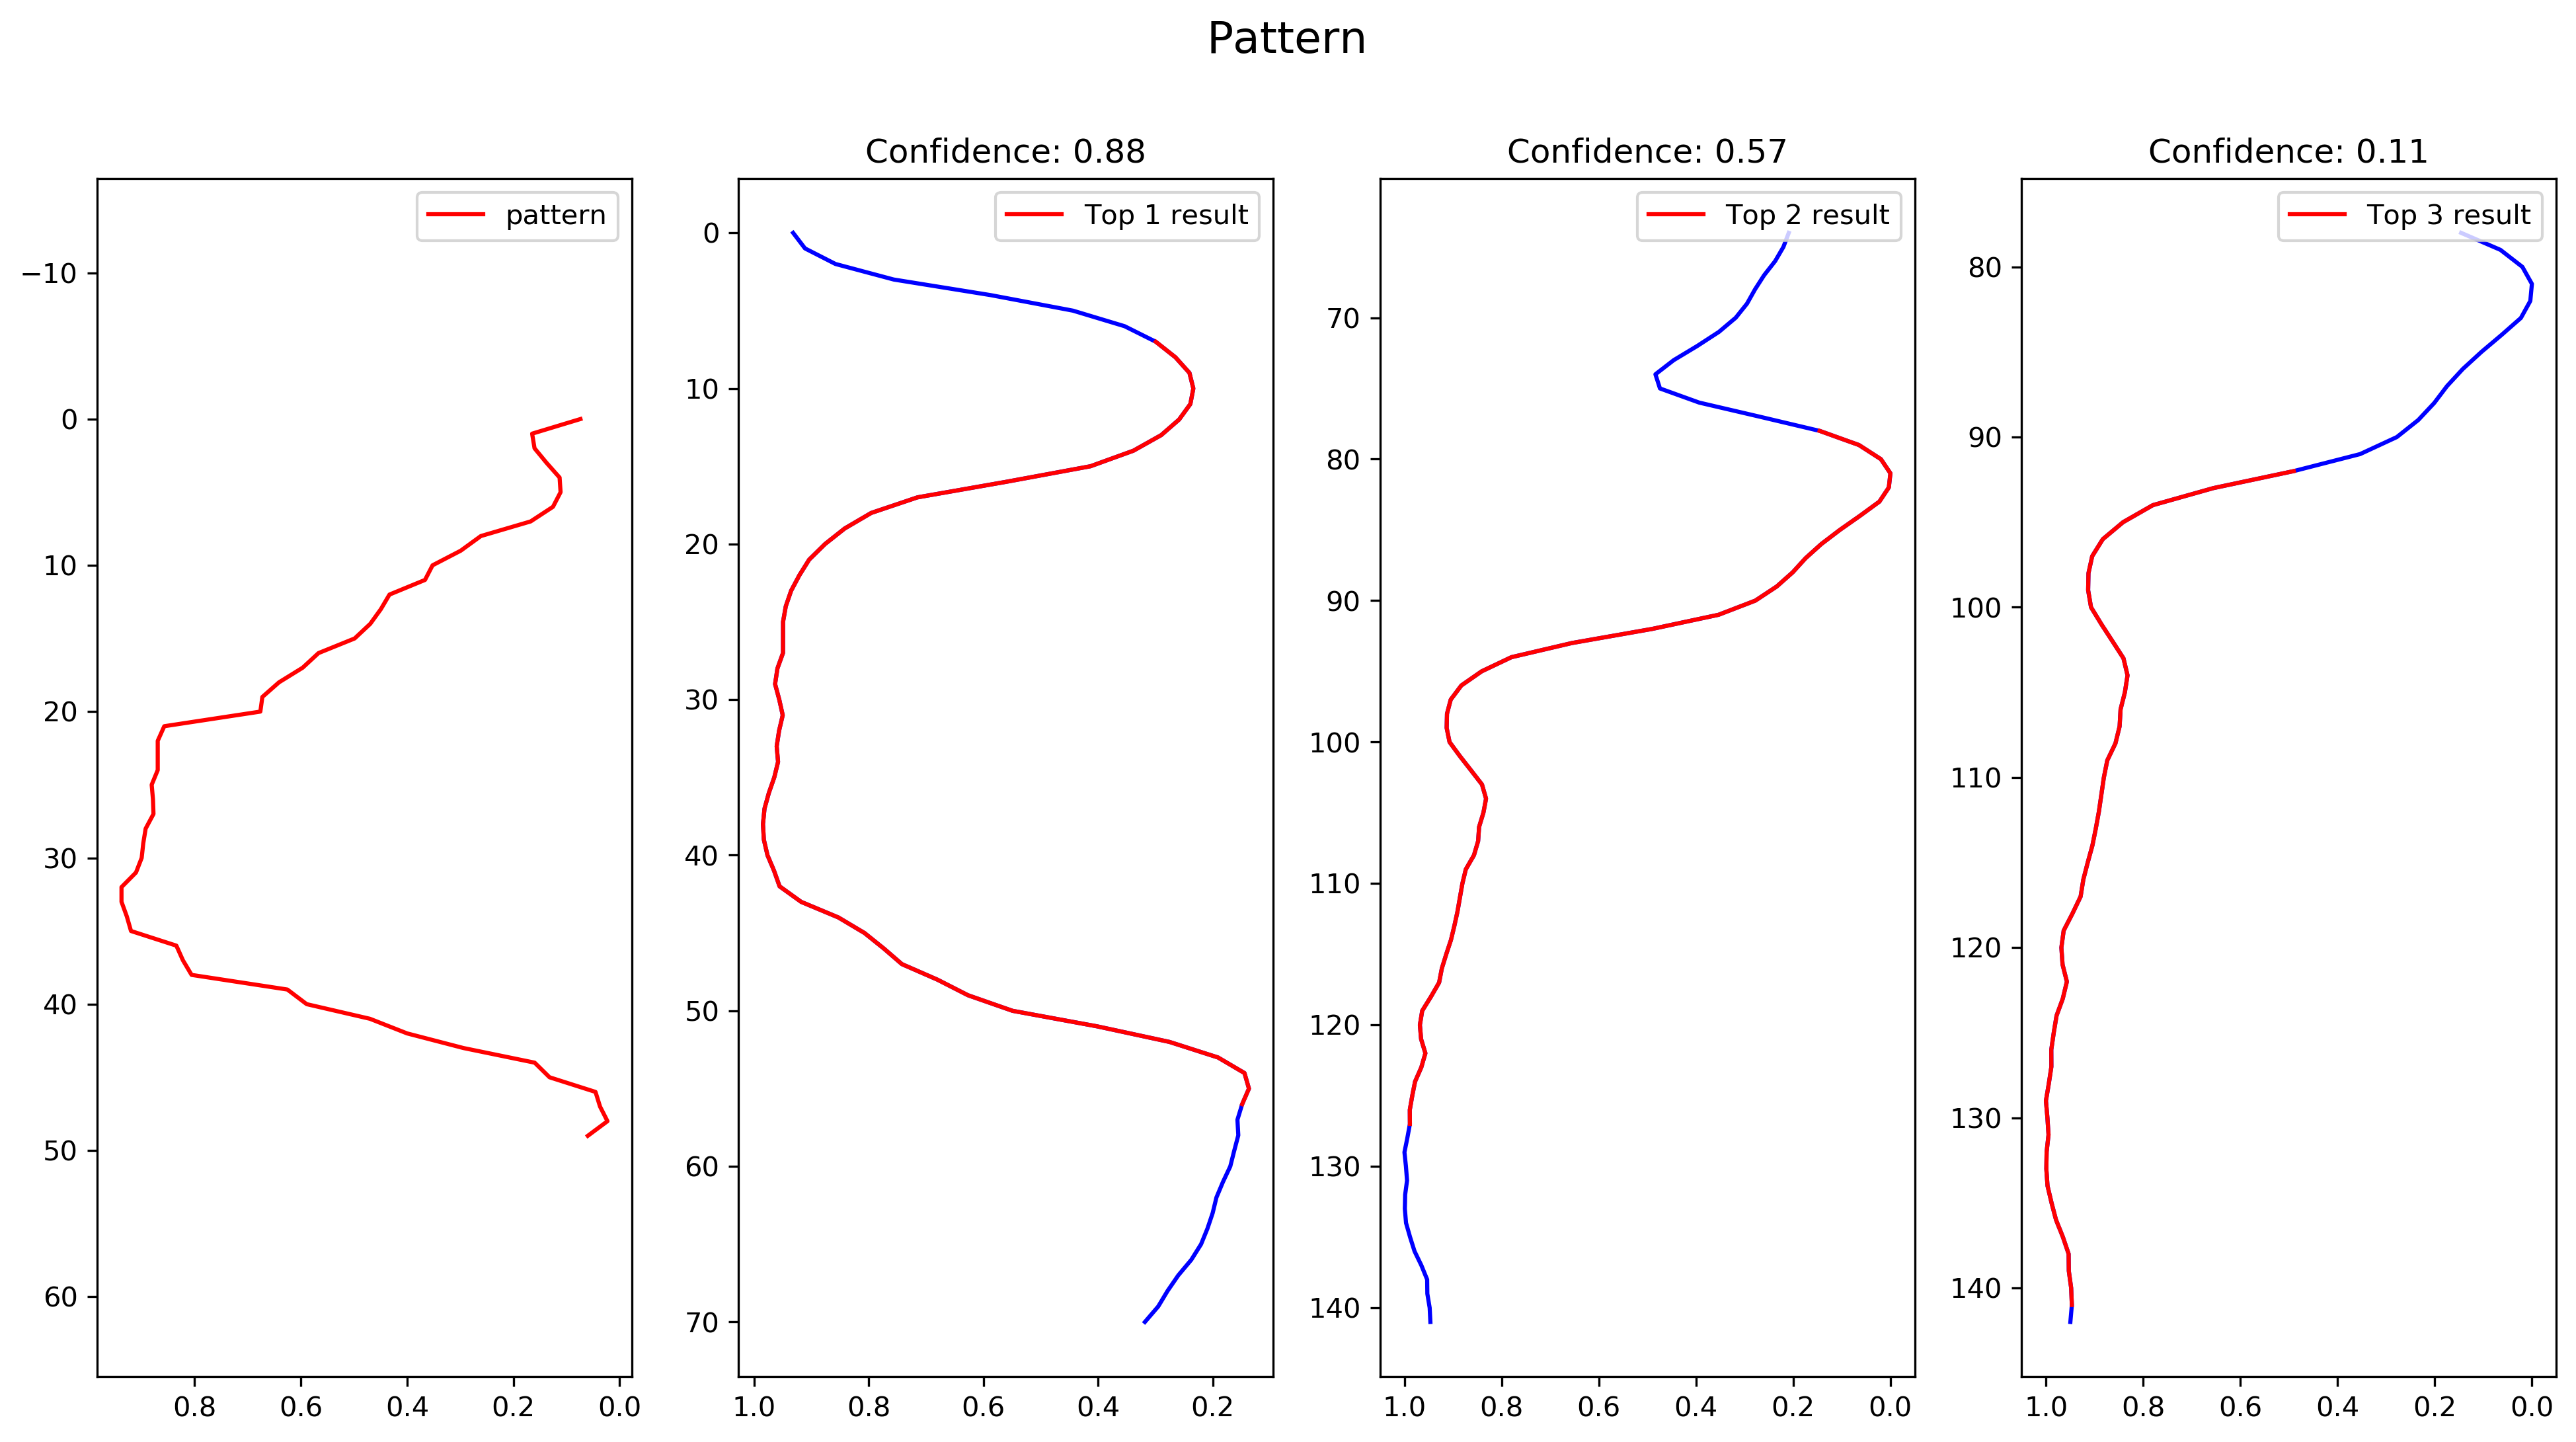

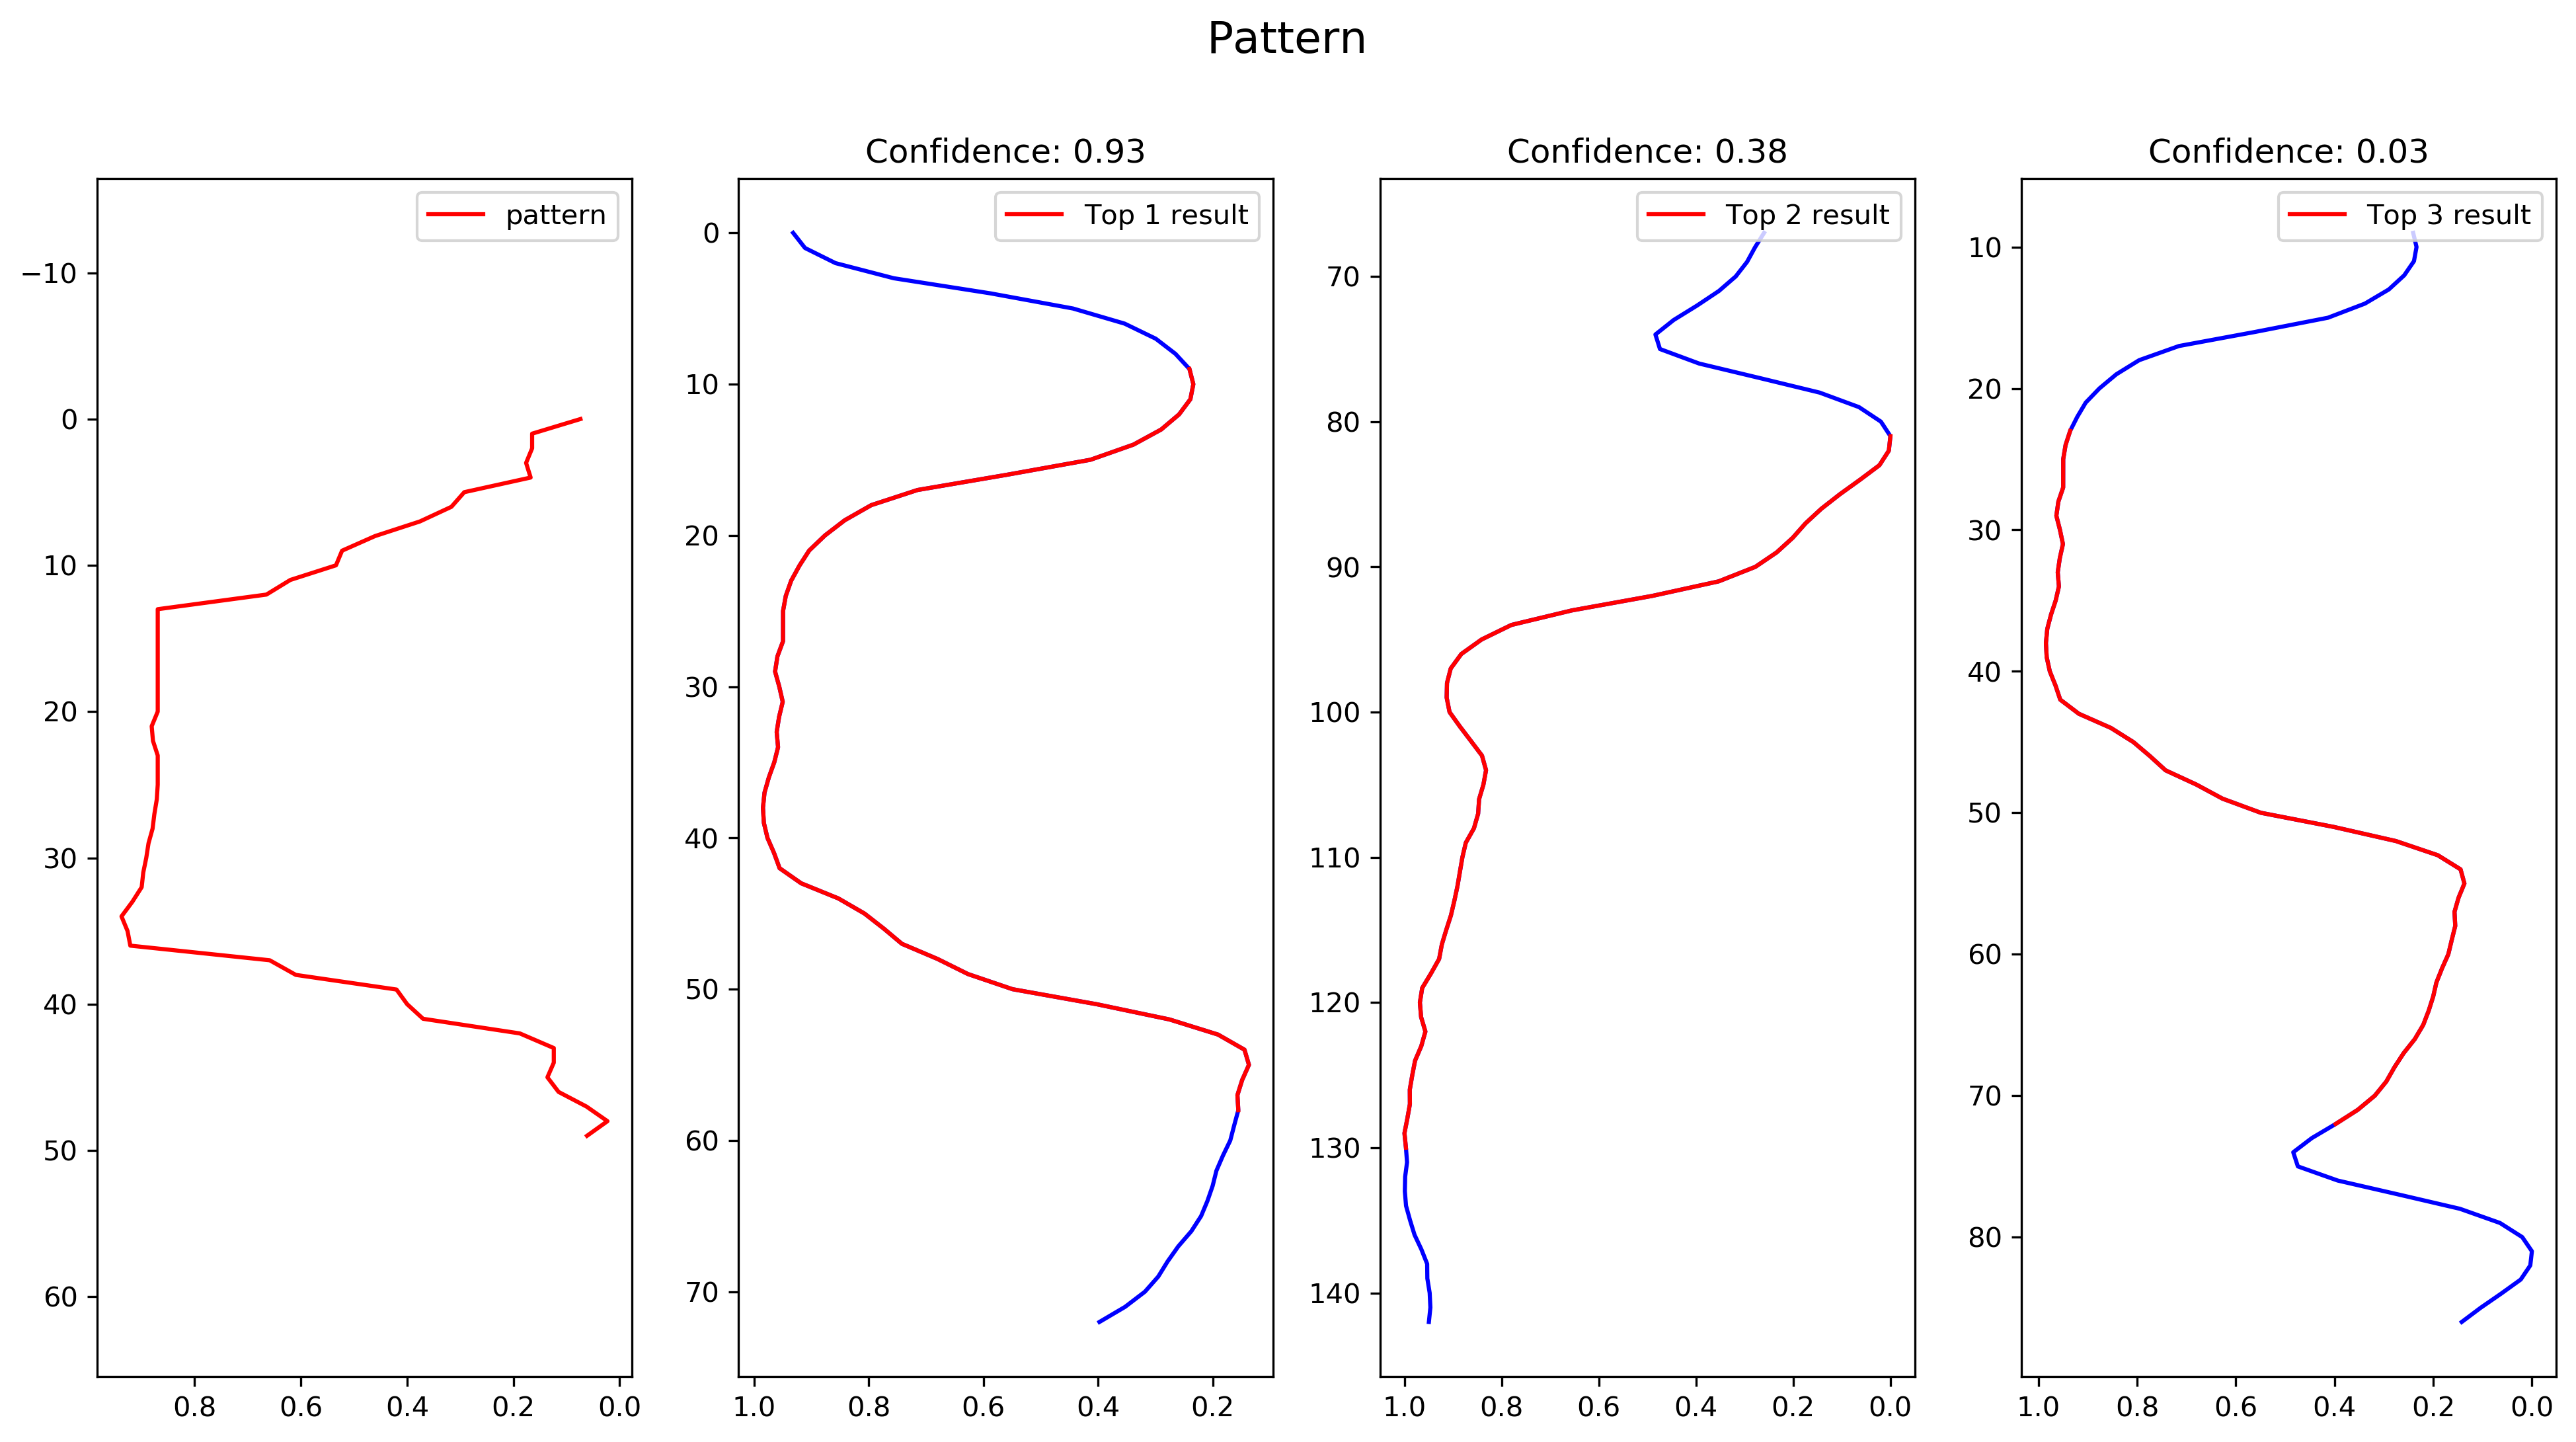

In [14]:
searcher.visualise_history()

Форма паттерна выглядит немного шумно, но это не мешает алгоритму узнавать его в данных. Самое главное, что здесь делают аугментации — изменяют длину паттерна. 

Видно, что в первом поиске алгоритм почти нашёл паттерн. Но из-за того, что кривая длиннее, чем нужно, уверенность не очень высока, а границы не совсем точны. Дальше идёт несколько неудачных попыток. И наконец, последняя аугментация точно попала в размер паттерна в реальных данных. Это позволило найти его в данных с 93% уверенностью и (на мой взгляд) достаточно точно выделить границы